In [60]:
# Set the current directory to be the repo's parent directory
# This needs to be be updated for your local machine
import os
os.chdir("/Users/erjo3868/repos/chem-embed/chem-embed")

from src.constants import DATA_DIR, EMBEDDINGS_DIR, INDICES_DIR
from src.create_and_query_index import add_and_query_index
from src.utils import pickle_and_compress, decompress_and_unpickle
from src.embed_smiles import embed_smiles, morgan_fingerprint_embedding
from src.plot_utils import fig_setup, set_title_axes_labels, finalize
import seaborn as sns
import faiss
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import time
from pathlib import Path
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

Embedding SMILES...
	 Embedding took 0.02 seconds


[12:47:48] Explicit valence for atom # 6 C, 5, is greater than permitted
/Users/erjo3868/repos/chem-embed/chem-embed/src/plot_utils.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


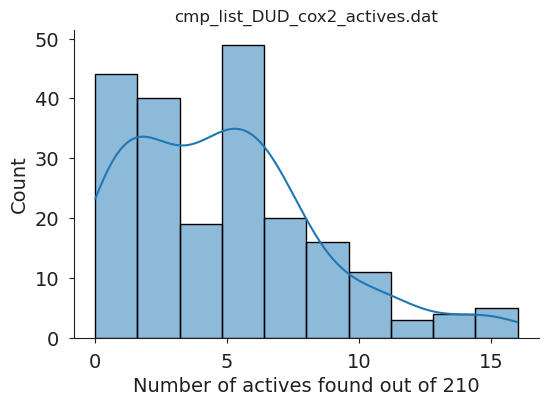

Embedding SMILES...
	 Embedding took 0.0 seconds


/Users/erjo3868/repos/chem-embed/chem-embed/src/plot_utils.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


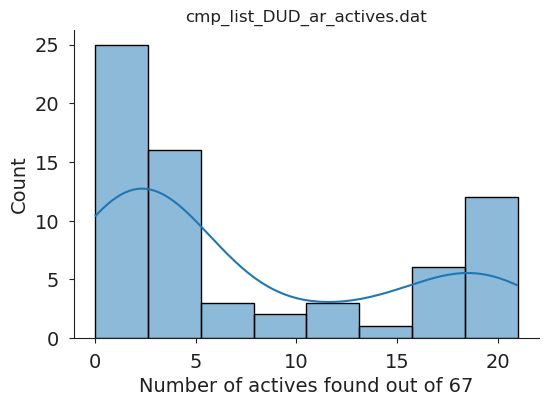

Embedding SMILES...
	 Embedding took 0.0 seconds


/Users/erjo3868/repos/chem-embed/chem-embed/src/plot_utils.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


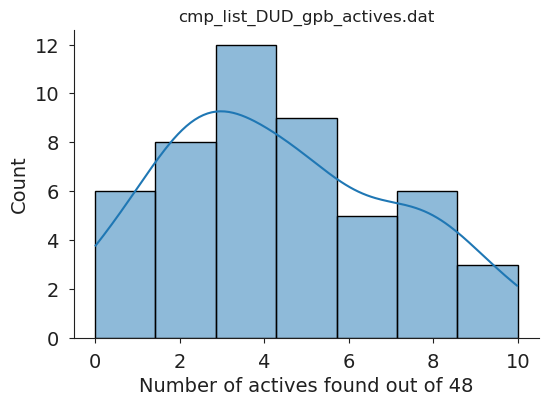

Embedding SMILES...
	 Embedding took 0.01 seconds


/Users/erjo3868/repos/chem-embed/chem-embed/src/plot_utils.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


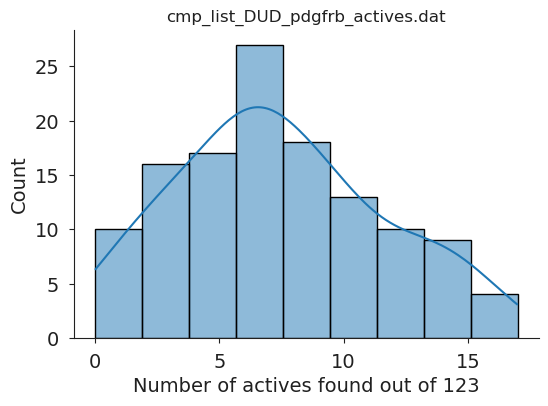

Embedding SMILES...
	 Embedding took 0.01 seconds


/Users/erjo3868/repos/chem-embed/chem-embed/src/plot_utils.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


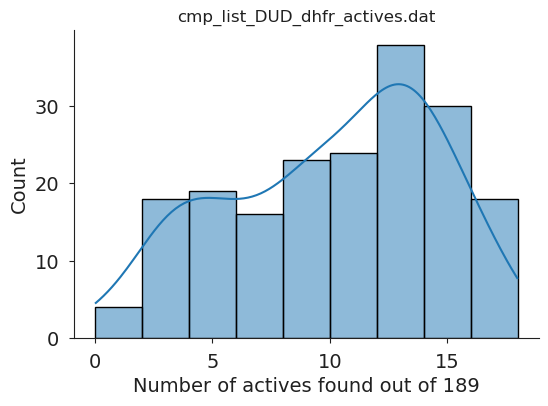

In [ ]:
# Hyperparameters
radius, embed_dim = 1, 1024

# Load ChEMBL embedded data
chembl_data = np.load(f"data/embeddings/chembl_v23_smiles_morgan_radius={radius}_dim={embed_dim}.npy")

# Load RDKit virtual screening SMILES
dud_paths = [Path(file_path) for file_path in glob.glob("../rdkit-virtual-screening-paper/data/DUD/*actives*.gz")][:5]
for actives_path in dud_paths:
    # actives_path = "../rdkit-virtual-screening-paper/data/DUD/cmp_list_DUD_ace_actives.dat.gz"
    active_smiles = pd.read_csv(
        actives_path, sep="\t", compression="gzip"
    )
    active_smiles = list(active_smiles["SMILES"])
    # active_smiles = set(active_smiles)

    # Embed data
    radius, embed_dim = 1, 1024
    embed_fcn = morgan_fingerprint_embedding
    active_data = embed_smiles(
        all_smiles=active_smiles,
        embed_fcn=embed_fcn,
        radius=radius,
        embed_dim=embed_dim
    )

    # Append the "active" SMILES data to the end of the ChEMBL data 
    active_start_row = chembl_data.shape[0]
    data = np.concatenate((chembl_data, active_data))
    assert np.all(data[active_start_row:] == active_data)

    # Add vectors to index
    index = faiss.IndexFlatL2(embed_dim)
    index.add(data)

    # Query index
    distances, ids = index.search(active_data, 50)

    # Determine the number of actives found in the NN searches
    active_indices = set(range(active_start_row, data.shape[0]))
    # len(active_indices)
    number_of_actives_found = []
    for nn_set in ids:
        number_of_actives_found.append(
            len(set(nn_set).intersection(active_indices)) - 1 # the minus one is to not count oneself
        )

    # Histogram of number of actives found in each NN search
    _, axs = fig_setup(1, 1)
    _=sns.histplot(number_of_actives_found, kde=True, ax=axs[0])
    set_title_axes_labels(
        ax=axs[0], xlabel=f"Number of actives found out of {active_data.shape[0]-1}",
        title=str(actives_path.stem),
        ylabel="Count"
    )
    finalize(axs)
    plt.show()

In [51]:
distances, ids = index.search(active_data, 50)

/Users/erjo3868/repos/chem-embed/chem-embed/src/plot_utils.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


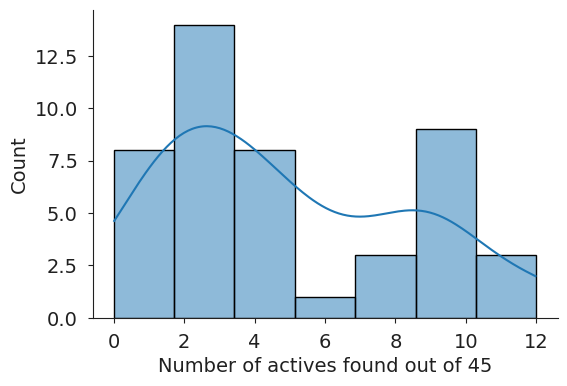

In [ ]:
active_indices = set(range(active_start_row, data.shape[0]))
# len(active_indices)
number_of_actives_found = []
for nn_set in ids:
    number_of_actives_found.append(
        len(set(nn_set).intersection(active_indices)) - 1 # the minus one is to not count oneself
    )

_, axs = fig_setup(1, 1)
_=sns.histplot(number_of_actives_found, kde=True, ax=axs[0])
set_title_axes_labels(
    ax=axs[0], xlabel=f"Number of actives found out of {active_data.shape[0]-1}",
    title=str(actives_path.stem),
    ylabel="Count"
)

finalize(axs)